# Grid search

## O que é?

Grid search é um método de otimização hiperparamétrica utilizado em modelos de aprendizado de máquina. Consiste em aplicar um conjunto de valores de hiperparâmetros em um modelo e obter a melhor configuração para esse. No grid search cada hiperparâmetro recebe uma lista de possíveis valores e TODAS as combinações são testadas, o que acaba gerando um altíssimo custo computacional, sendo o método de HPO mais "caro", computacionalmente falando (ZHENG, Alice. Evaluating Machine Learning Models, O'REILLY, pág 31).

Podemos encarar a "busca em grade" como, literalmente, uma grade de hiperparâmetros onde todas combinações são testadas.

### Exemplo

Para o exemplo utilizarei a base de dados do facebook, já utilizada anteriormente, e os modelos SVM, KNN e Decision Trees

In [1]:
# importando dependências
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.tree import DecisionTreeRegressor

In [2]:
#Recolhendo dados do facebook e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2019, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)
df.head()

,Target,Close 1,Close 2,Close 3,Close 4
4,142.529999,138.050003,137.949997,131.740005,135.679993
5,144.229996,142.529999,138.050003,137.949997,131.740005
6,144.199997,144.229996,142.529999,138.050003,137.949997
7,143.800003,144.199997,144.229996,142.529999,138.050003
8,145.389999,143.800003,144.199997,144.229996,142.529999


In [3]:
#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Criando modelos "default"

Os seguintes modelos utilizarão apenas a configuração padrão de hiperparâmetros, sem ajustar nenhum, serão utilisados como linha de base

In [4]:
# configuração default para svr
# kernel = rbf, degree = 3, gamma = scale, coef0 = 0.0, tol = 1e-3, C=1.0,
# epsilon = 0.1, shrinking = True, cache_size = 200, verbose = False, max_iter = -1
svm_default = SVR()

# configuração default para knn
# n_neighbors = 5, weights = uniform, algorithm = auto, leaf_size = 30, p=2, metric=minkowski, metric_params=None, n_jobs=None
knn_default = KNR()

# configuração default para decision tree
# criterion=mse, splitter=best, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
# min_weight_fraction_leaf = 0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0
dt_default = DecisionTreeRegressor()

### Criando listas de hiperparâmetros

In [5]:
svm_hp = {'kernel':['rbf','linear'], 'gamma':['scale','auto'], 'C':[0.7,1.0], 'epsilon':[0.1,0.15,0.3]}

knn_hp = {'n_neighbors':[3,5,9,11], 'weights': ['uniform','distance'], 'algorithm':['auto', 'ball_tree', 'brute'], 
          'p':[1,2]}

dt_hp = {'criterion': ['mse','friedman_mse','mae'], 'splitter':['best','random'],'min_samples_split':[2,5,10,15],
        'max_features':['auto','sqrt','log2']}

### Criando modelos que serão ajustados

In [6]:
# modelo_ajustado = GridSearchCV(modelo_padrão, lista_de_hp)

svm_tune = GridSearchCV(svm_default, svm_hp)

knn_tune = GridSearchCV(knn_default, knn_hp)

dt_tune = GridSearchCV(dt_default, dt_hp)

### Treinando modelos tunados

In [7]:
# Ajustando hp do modelo svm
svi = time.time()

svm_tune.fit(X_train, y_train)

svf = time.time()

svm_time = svf-svi

In [8]:
#Retornando parâmetros
print(svm_tune.best_params_)

{'C': 1.0, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'linear'}


In [9]:
# Ajustando hp do modelo knn
kni = time.time()

knn_tune.fit(X_train, y_train)

knf = time.time()

knn_time = knf-kni

In [10]:
#Retornando parâmetros
print(knn_tune.best_params_)

{'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


In [11]:
# Ajustando hp do modelo dt
dti = time.time()

dt_tune.fit(X_train, y_train)

dtf = time.time()

dt_time = dtf-dti

In [12]:
#Retornando parâmetros
print(dt_tune.best_params_)

{'criterion': 'mae', 'max_features': 'auto', 'min_samples_split': 10, 'splitter': 'best'}


### Criando modelos baseado no grid search

In [13]:
svm_tuned = SVR(C= 1.0, epsilon= 0.3, gamma= 'scale', kernel= 'linear')

knn_tuned = KNR(algorithm= 'auto', n_neighbors= 9,p= 2, weights= 'distance')

dt_tuned = DecisionTreeRegressor(criterion= 'mae', max_features= 'auto', min_samples_split= 15, splitter= 'best')

### Treinando modelos ajustados e modelos padrão

In [14]:
#Modelos padrão
svm_default.fit(X_train,y_train)
knn_default.fit(X_train,y_train)
dt_default.fit(X_train,y_train)

#Modelos ajustados
svm_tuned.fit(X_train,y_train)
knn_tuned.fit(X_train,y_train)
dt_tuned.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mae', max_features='auto',
                      min_samples_split=15)

In [15]:
#Recolhendo pontuações

#Modelos padrão
svm_default_score = svm_default.score(X_test,y_test)
knn_default_score = knn_default.score(X_test,y_test)
dt_default_score = dt_default.score(X_test,y_test)

#Modelos ajustados
svm_tuned_score = svm_tuned.score(X_test,y_test)
knn_tuned_score = knn_tuned.score(X_test,y_test)
dt_tuned_score = dt_tuned.score(X_test,y_test)

In [16]:
#Recolhendo previsões

#Modelos padrão
svm_default_pred = svm_default.predict(X)
knn_default_pred = knn_default.predict(X)
dt_default_pred = dt_default.predict(X)

#Modelos ajustados
svm_tuned_pred = svm_tuned.predict(X)
knn_tuned_pred = knn_tuned.predict(X)
dt_tuned_pred = dt_tuned.predict(X)

In [17]:
print('--RELATÓRIO--')

print('SVM:')
print('Default score: ',svm_default_score)
print('Tuned score: ',svm_tuned_score)
print('--------------------')

print('KNN:')
print('Default score: ',knn_default_score)
print('Tuned score: ',knn_tuned_score)
print('--------------------')

print('Decision Tree:')
print('Default score: ',dt_default_score)
print('Tuned score: ',dt_tuned_score)
print('--------------------')

--RELATÓRIO--
SVM:
Default score:  0.85605189803503
Tuned score:  0.9507001584219483
--------------------
KNN:
Default score:  0.9296488936282796
Tuned score:  0.9319514383394228
--------------------
Decision Tree:
Default score:  0.8949814600846335
Tuned score:  0.9352060184645302
--------------------


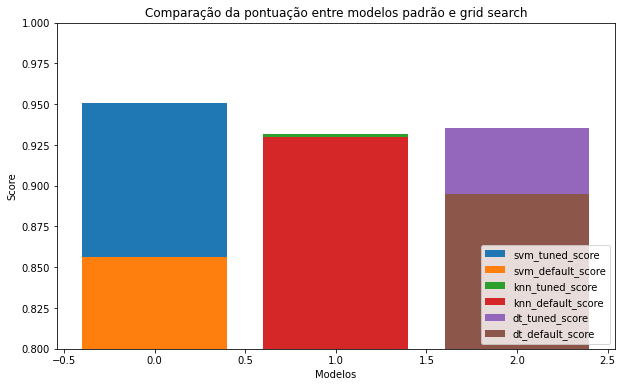

In [18]:
#Visualizando resultados

plt.figure(figsize=(10,6))

plt.bar(0, svm_tuned_score, label='svm_tuned_score')
plt.bar(0, svm_default_score, label='svm_default_score')

plt.bar(1, knn_tuned_score, label='knn_tuned_score')
plt.bar(1, knn_default_score, label='knn_default_score')

plt.bar(2, dt_tuned_score, label='dt_tuned_score')
plt.bar(2, dt_default_score, label='dt_default_score')

plt.ylim(0.8, 1.0)
plt.ylabel('Score')
plt.xlabel('Modelos')
plt.title('Comparação da pontuação entre modelos padrão e grid search')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Decision Tree')

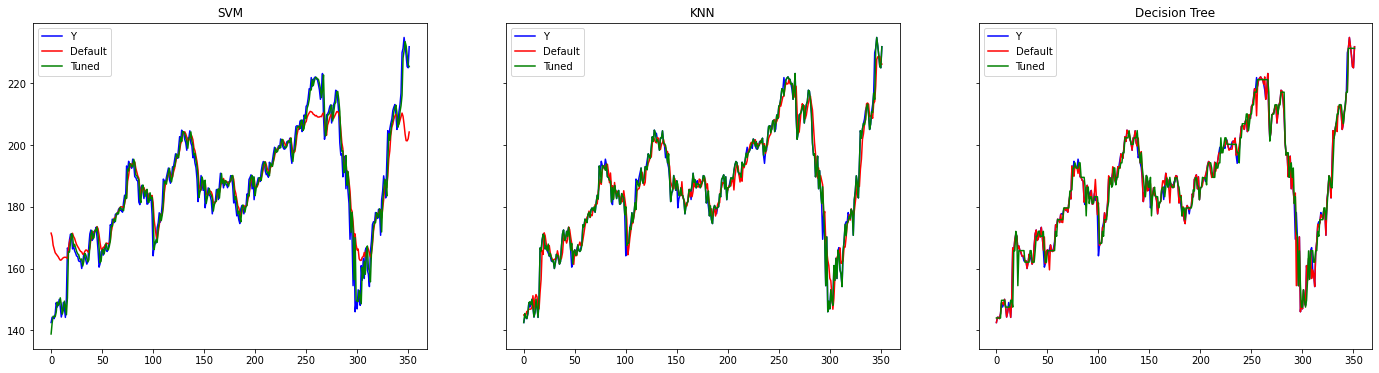

In [19]:
#plotando previsões

fig, ax = plt.subplots(nrows = 1, ncols = 3, sharey = True,  figsize=(24,6))

ax[0].plot(y, color='blue', label='Y')
ax[0].plot(svm_default_pred, color='red', label='Default')
ax[0].plot(svm_tuned_pred, color='green', label='Tuned')
ax[0].legend()
ax[0].set_title("SVM")

ax[1].plot(y, color='blue', label='Y')
ax[1].plot(knn_default_pred, color='red', label='Default')
ax[1].plot(knn_tuned_pred, color='green', label='Tuned')
ax[1].legend()
ax[1].set_title("KNN")

ax[2].plot(y, color='blue', label='Y')
ax[2].plot(dt_default_pred, color='red', label='Default')
ax[2].plot(dt_tuned_pred, color='green', label='Tuned')
ax[2].legend()
ax[2].set_title("Decision Tree")